# Flattener

In [1]:
%pylab inline
import scipy.signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = []
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)
with bioformats.ImageReader("8x8x8nm.mrc.am") as reader:
    i = 0
    while True:
        try:
            data.append(reader.read(z=i, rescale=False))
        except javabridge.JavaException:
            break
        i +=  1
javabridge.kill_vm()

In [3]:
import gc

In [4]:
data = np.asarray(data)
gc.collect()

0

In [5]:
import dask
import dask.multiprocessing

In [6]:
def find_max_line(d, minidx=600):
    deriv = scipy.signal.savgol_filter(d * 1.0, 21, 3, 1)
    return deriv[minidx:].argmax() + minidx

dfind_max_line = dask.delayed(find_max_line, pure=True)

In [7]:
type(find_max_line(data[0, :, 0]))

numpy.int64

In [8]:
import tqdm

In [17]:
def find_max_plane(d, minidx=0):
    return np.array([find_max_line(dd, minidx) for dd in d.T], np.uint16)

dfind_max_plane = dask.delayed(find_max_plane, pure=True)

In [20]:
%time a = np.array(find_max_plane(data[1000]))

Wall time: 14.5 s


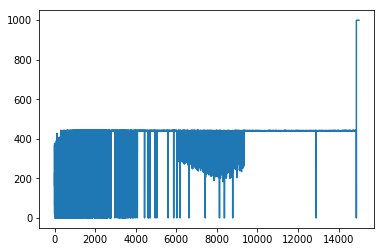

In [21]:
plt.plot(a)

In [22]:
import dask.array

In [23]:
from dask.diagnostics import ProgressBar

In [24]:
result = dask.array.stack([dask.array.from_delayed(dfind_max_plane(d), (data.shape[-1], ), np.uint16)
                           for d in tqdm.tqdm_notebook(data)])

HBox(children=(IntProgress(value=0, max=5307), HTML(value='')))

In [25]:
with ProgressBar():
    baseline = result.compute(get=dask.multiprocessing.get)

[########################################] | 100% Completed | 45min 28.5s


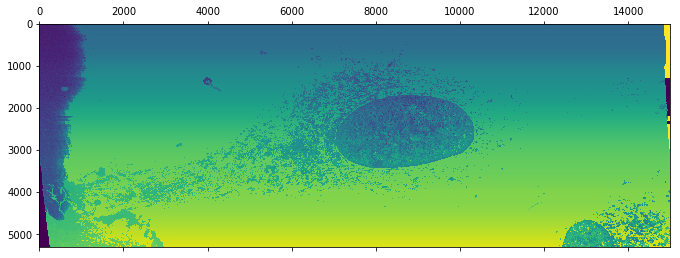

In [28]:
plt.matshow(scipy.ndimage.median_filter(baseline, 21))

## Plan

Only FIB $z$ (LM $y$) direction is misaligned, so only need to flatten in that direciton. We should take the results of finding the boundry, average along FIB $x$ and then smooth. Then we can shift each FIB $xy$ plane by this amount.

In [26]:
import skimage.external.tifffile as tif

In [27]:
tif.imsave("8x8x8nm_baseline.tif", baseline, compress=6)

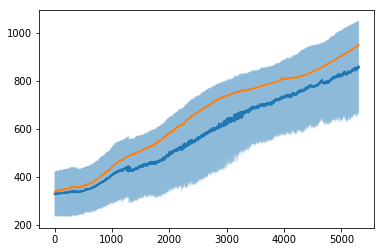

In [29]:
bm = np.mean(baseline, 1)
bm2 = np.median(baseline, 1)
bs = baseline.std(1)
x = np.arange(bs.size)
plt.fill_between(x, bm - bs, bm + bs, alpha=0.5)

plt.plot(x, bm)
plt.plot(x, bm2)

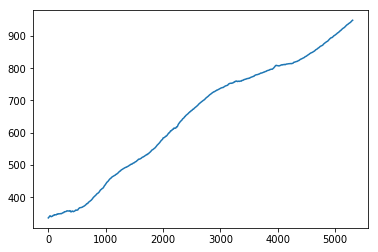

In [30]:
plt.plot(x, scipy.signal.savgol_filter(bm2, 21, 3))

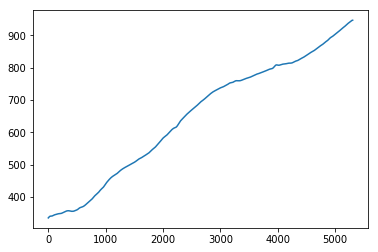

In [31]:
plt.plot(scipy.signal.filtfilt(*scipy.signal.butter(3, 0.025), bm2))

(-2, 2)

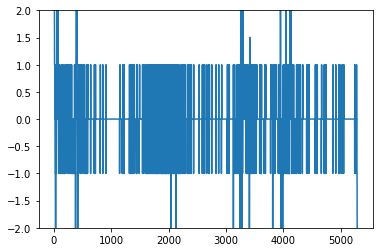

In [32]:
plt.plot(scipy.ndimage.median_filter(bm2, 100) - bm2)
# plt.plot(bm2)
plt.ylim([-2, 2])

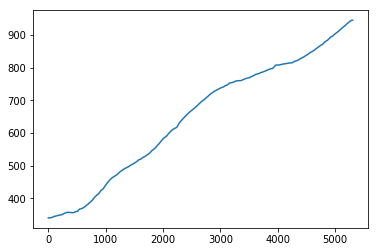

In [38]:
bm3 = scipy.ndimage.median_filter(bm2, 100)
smooth_bm2 = (scipy.signal.filtfilt(*scipy.signal.butter(3, 0.05), bm3))
# plt.plot(bm2)
plt.plot(smooth_bm2)

(-2, 2)

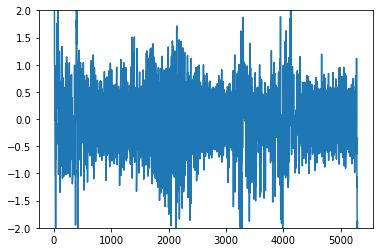

In [39]:
plt.plot(smooth_bm2 - bm2)
# plt.plot(bm2)
# plt.xlim([1000, None])
plt.ylim([-2, 2])

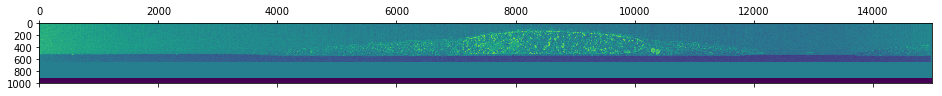

In [40]:
plt.matshow(scipy.ndimage.interpolation.shift(data[3000], (-(smooth_bm2[3000] - smooth_bm2.mean()), 0), order=1))

In [41]:
smooth_bm2_nomean = smooth_bm2 - smooth_bm2.mean()

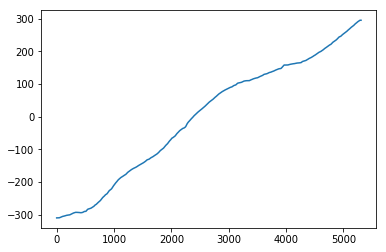

In [42]:
plt.plot(smooth_bm2_nomean)

In [43]:
with tif.TiffWriter("8x8x8nm_flat.tif", bigtiff=True) as mytif:
    for d, shift in tqdm.tqdm(zip(data, smooth_bm2_nomean), total=data.shape[0]):
        shifted_img = scipy.ndimage.interpolation.shift(d, (-shift, 0), order=1)
        mytif.save(shifted_img, compress=6)

100%|████████████████████████████████████████████████████████████████████████████| 5307/5307 [1:43:17<00:00,  1.17s/it]
